In [61]:
#!/bin/python3

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import pandas as pd
df  = pd.read_csv("FINAL_FROM_DF.csv")
df = df[df["SYMBOL"]=="ADANIPOWER"]["OPEN"]
df.head()

In [ ]:
data = df.tolist()

n1 = int(len(data)*0.8)
n2 = int(len(data)*0.9)
train_data = data[:n1]
val_data =data[n1:n2]
test_data = data[n2:]
len(train_data),len(val_data),len(test_data)

In [66]:
batch_size=7
seq_len =10
def get_batch(split=None):
    data = torch.tensor(train_data) if split == None else torch.tensor(split)
    ix =[i for i in range(0,len(data)-seq_len)]
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:1+i+seq_len][-1] for i in ix])
    return x,y
    

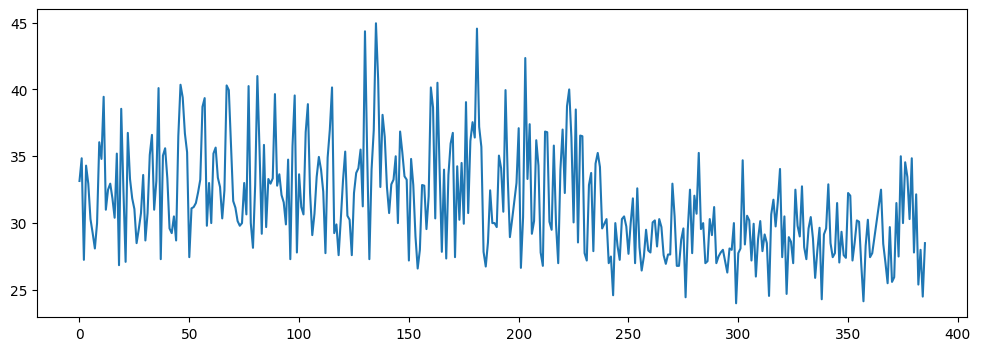

In [67]:
x_train,y_train =get_batch()
plt.figure(figsize=(12, 4)) 
plt.plot(range(len(y_train)),y_train)

In [68]:
x_train[:5],len(x_train)

(tensor([[27.1000, 36.6000, 38.6000, 33.0000, 39.7500, 33.8000, 30.9500, 39.5000,
          33.1000, 28.6500],
         [36.6000, 38.6000, 33.0000, 39.7500, 33.8000, 30.9500, 39.5000, 33.1000,
          28.6500, 33.1500],
         [38.6000, 33.0000, 39.7500, 33.8000, 30.9500, 39.5000, 33.1000, 28.6500,
          33.1500, 34.8500],
         [33.0000, 39.7500, 33.8000, 30.9500, 39.5000, 33.1000, 28.6500, 33.1500,
          34.8500, 27.2500],
         [39.7500, 33.8000, 30.9500, 39.5000, 33.1000, 28.6500, 33.1500, 34.8500,
          27.2500, 34.3000]]),
 386)

In [69]:
class Making_rnn(nn.Module):
    def __init__(self, fan_in, hidden_dim, fan_out):
        super().__init__()
        self.fan_in = fan_in
        self.fan_out = fan_out
        self.hidden_dim = hidden_dim
        self.activation_tanh = nn.LeakyReLU()
        self.wo1 = nn.Linear(fan_in + hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, fan_out)
        self.init_hidden_pred = torch.zeros(self.hidden_dim)
        self.h_pred = None
    def forward(self, x):
        if self.h_pred is None:
            self.h_pred = self.init_hidden_pred
        h_cat = torch.cat((x, self.h_pred.detach()))
        self.h_cat = h_cat
        h_new = self.activation_tanh(self.wo1(h_cat))
        self.h_pred=h_new
        out = self.fc(self.h_pred)
        return out

In [70]:
model =Making_rnn(seq_len,20,1)
Mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# torch.autograd.set_detect_anomaly(True)


In [71]:
epocs = 50
loss_arr = []
y_pred_arr = []
for i in range(len(x_train)):
    y_preact =model(x_train[i])
    for _ in range(epocs):
        optimizer.zero_grad()
        y_pred = model(x_train[i])
        loss = Mse_loss(y_pred,y_train[i])
        loss.backward()
        optimizer.step()
    
    print(loss.item(),i)
    loss_arr.append(loss.item())
    y_pred_arr.append(y_preact.item())
    


/home/nox/Desktop/drive/controbution/neural_network/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.00494384765625 0
0.10978671908378601 1
0.14500737190246582 2
0.06081210449337959 3
0.0017428994178771973 4
0.013736933469772339 5
0.0011201235465705395 6
8.944422006607056e-06 7
0.02503788471221924 8
0.2793078124523163 9
0.014705300331115723 10
0.07646318525075912 11
0.0811270922422409 12
2.5432149413973093e-05 13
0.00011384267418179661 14
0.0012960868189111352 15
0.0012231208384037018 16
0.005918965674936771 17
0.0221170075237751 18
0.028525764122605324 19
0.00988861732184887 20
0.018659695982933044 21
0.020604662597179413 22
0.002033771015703678 23
0.00022190251911524683 24
3.3488162443973124e-05 25
0.001067018718458712 26
2.1517276763916016e-05 27
0.0009023315506055951 28
6.868052878417075e-06 29
0.00046412250958383083 30
0.0018592852866277099 31
0.0020589653868228197 32
0.00021491212828550488 33
0.009439019486308098 34
0.0001682201400399208 35
0.0013218953972682357 36
0.004852541722357273 37
4.1561725083738565e-07 38
9.313225746154785e-10 39
1.7289130482822657e-07 40
3.7923782656

KeyboardInterrupt: 

In [75]:
plt.imshow(model.wo1.weight.grad>0.99,cmap="grey") #almost every thing in the neuron wo1 is dead 

TypeError: '>' not supported between instances of 'NoneType' and 'float'

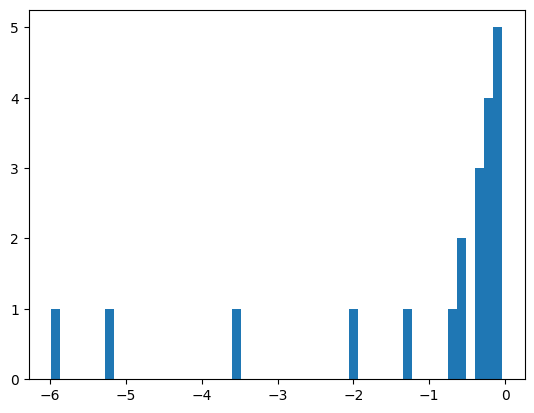

In [73]:
plt.hist(model.h_pred.view(-1).tolist(),50);# See h_pred is -1 and 1 mean the model is not learning

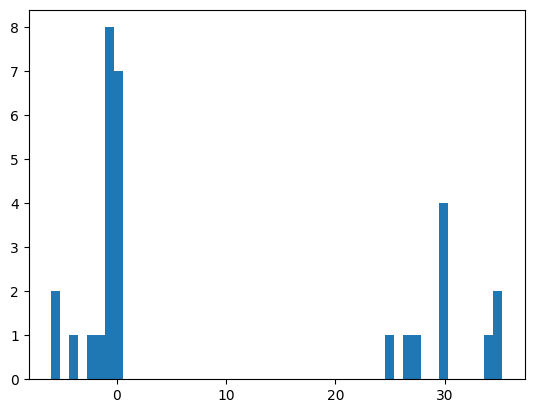

In [74]:
plt.hist(model.h_cat.view(-1).tolist(),50);

In [ ]:
x,y =get_batch()
plt.figure(figsize=(12, 4)) 
plt.plot(range(len(y_train)),y_train,color='red')
plt.plot(range(len(y_pred_arr)),y_pred_arr,color='Blue')


In [ ]:
plt.plot(loss_arr)

In [ ]:
x_test,y_test = get_batch(test_data)
y_test_pred = [model(x_test[i]).item() for i in range(len(x_test))]

In [ ]:
plt.figure(figsize=(12, 4)) 
plt.plot(range(len(y_test)),y_test_pred)
plt.plot(range(len(y_test)),y_test)